# Task 5: Evaluation

## Overview
This notebook implements comprehensive evaluation of the trained models for C-MAPSS aircraft engine RUL prediction. We analyze model performance, conduct error analysis, create visualizations, and provide business insights.

## Objectives
- Evaluate model performance on test data
- Compare different modeling approaches
- Analyze prediction errors and patterns
- Assess business impact and practical considerations
- Generate actionable insights for deployment

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
RANDOM_STATE = 42
interactive = True  # Set to False for static plots only

# Set up paths
DATA_PATH = Path('../source_data')
INTERMEDIATE_PATH = Path('../intermediate_data')
RESULTS_PATH = Path('../results_data')

print("Libraries imported and paths configured successfully!")

Libraries imported and paths configured successfully!


## Phase 5.1: Data Loading and Setup

### Step 5.1.1: Environment Setup and Data Import
Load modeling results, test predictions, and true RUL values for comprehensive evaluation.

In [2]:
# Load modeling results and performance summary
performance_summary = pd.read_csv(INTERMEDIATE_PATH / 'modeling_performance_summary.csv')
test_predictions = pd.read_csv(INTERMEDIATE_PATH / 'modeling_test_predictions.csv')

# Load true test RUL values
true_rul = pd.read_csv(INTERMEDIATE_PATH / 'data_exploration_test_rul.csv')

# Load test data to understand prediction context
test_features = pd.read_csv(INTERMEDIATE_PATH / 'feature_engineering_test_features.csv')

# Load metadata
with open(INTERMEDIATE_PATH / 'modeling_metadata.json', 'r') as f:
    modeling_metadata = json.load(f)

print(f"Performance summary shape: {performance_summary.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"True RUL shape: {true_rul.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"\nBest model: {modeling_metadata.get('best_model', 'Not specified')}")

Performance summary shape: (10, 6)
Test predictions shape: (13096, 2)
True RUL shape: (100, 2)
Test features shape: (13096, 59)

Best model: Not specified


In [3]:
# Prepare evaluation dataset
# Get the final prediction for each engine (last cycle)
final_predictions = test_predictions.groupby('unit_id').tail(1).reset_index(drop=True)
final_predictions = final_predictions.rename(columns={'predicted_RUL': 'predicted_rul'})

# Merge with true RUL values
evaluation_data = pd.merge(final_predictions, true_rul, on='unit_id')
evaluation_data = evaluation_data.rename(columns={'RUL': 'true_rul'})

# Calculate prediction errors
evaluation_data['error'] = evaluation_data['predicted_rul'] - evaluation_data['true_rul']
evaluation_data['abs_error'] = np.abs(evaluation_data['error'])
evaluation_data['squared_error'] = evaluation_data['error'] ** 2
evaluation_data['percent_error'] = (evaluation_data['error'] / evaluation_data['true_rul']) * 100

print(f"Evaluation dataset shape: {evaluation_data.shape}")
print(f"\nFirst few predictions vs actuals:")
print(evaluation_data[['unit_id', 'predicted_rul', 'true_rul', 'error']].head(10))

Evaluation dataset shape: (100, 7)

First few predictions vs actuals:
   unit_id  predicted_rul  true_rul      error
0        1     152.952773       112  40.952773
1        2     145.199652        98  47.199652
2        3      75.661660        69   6.661660
3        4      69.439528        82 -12.560472
4        5      95.487157        91   4.487157
5        6     101.387485        93   8.387485
6        7      96.957545        91   5.957545
7        8      97.843631        95   2.843631
8        9     141.724932       111  30.724932
9       10      87.462567        96  -8.537433


### Step 5.1.2: Model Performance Metrics Calculation
Calculate comprehensive performance metrics for the best model predictions.

In [4]:
# Calculate comprehensive performance metrics
def calculate_phm_score(y_true, y_pred):
    """Calculate PHM (Prognostic and Health Management) score"""
    errors = y_pred - y_true
    score = 0
    for error in errors:
        if error < 0:  # Early prediction
            score += np.exp(-error/13) - 1
        else:  # Late prediction
            score += np.exp(error/10) - 1
    return score

# Performance metrics
rmse = np.sqrt(mean_squared_error(evaluation_data['true_rul'], evaluation_data['predicted_rul']))
mae = mean_absolute_error(evaluation_data['true_rul'], evaluation_data['predicted_rul'])
r2 = r2_score(evaluation_data['true_rul'], evaluation_data['predicted_rul'])
mape = np.mean(np.abs(evaluation_data['percent_error']))
phm_score = calculate_phm_score(evaluation_data['true_rul'], evaluation_data['predicted_rul'])

# Additional metrics
median_error = np.median(evaluation_data['error'])
max_error = np.max(evaluation_data['abs_error'])
min_error = np.min(evaluation_data['abs_error'])
std_error = np.std(evaluation_data['error'])

# Create metrics summary
metrics_summary = {
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2,
    'MAPE (%)': mape,
    'PHM Score': phm_score,
    'Median Error': median_error,
    'Max Absolute Error': max_error,
    'Min Absolute Error': min_error,
    'Error Std Dev': std_error,
    'Sample Size': len(evaluation_data)
}

print("Best Model Performance on Test Data:")
print("=" * 40)
for metric, value in metrics_summary.items():
    if metric in ['RMSE', 'MAE', 'Median Error', 'Max Absolute Error', 'Min Absolute Error', 'Error Std Dev']:
        print(f"{metric:20}: {value:.3f} cycles")
    elif metric == 'MAPE (%)':
        print(f"{metric:20}: {value:.2f}%")
    elif metric == 'R²':
        print(f"{metric:20}: {value:.6f}")
    else:
        print(f"{metric:20}: {value:.2f}")

Best Model Performance on Test Data:
RMSE                : 23.490 cycles
MAE                 : 15.486 cycles
R²                  : 0.680478
MAPE (%)            : 20.84%
PHM Score           : 70648.43
Median Error        : 2.913 cycles
Max Absolute Error  : 111.333 cycles
Min Absolute Error  : 0.791 cycles
Error Std Dev       : 22.450 cycles
Sample Size         : 100.00


## Phase 5.2: Model Comparison and Analysis

### Step 5.2.1: Cross-Model Performance Comparison
Compare performance across all trained models to understand relative strengths and weaknesses.

In [5]:
# Clean up performance summary (remove duplicates)
performance_clean = performance_summary.drop_duplicates(subset=['Model']).reset_index(drop=True)

# Sort by RMSE for better visualization
performance_clean = performance_clean.sort_values('RMSE').reset_index(drop=True)

print("Model Performance Ranking (by RMSE):")
print("=" * 60)
for idx, row in performance_clean.iterrows():
    print(f"{idx+1:2d}. {row['Model']:18} | RMSE: {row['RMSE']:8.3f} | R²: {row['R²']:8.6f} | PHM: {row['PHM_Score']:8.2f}")

# Identify top performers
top_3_models = performance_clean.head(3)
print(f"\nTop 3 Models:")
for idx, row in top_3_models.iterrows():
    print(f"  {idx+1}. {row['Model']} (RMSE: {row['RMSE']:.6f})")

Model Performance Ranking (by RMSE):
 1. Weighted Ensemble  | RMSE:    9.210 | R²: 0.982070 | PHM: 13970.27
 2. Voting Ensemble    | RMSE:    9.225 | R²: 0.982010 | PHM: 14120.23
 3. XGBoost            | RMSE:    9.382 | R²: 0.981393 | PHM: 31299.40
 4. LightGBM           | RMSE:    9.782 | R²: 0.979772 | PHM: 12053.26
 5. Gradient Boosting  | RMSE:   10.339 | R²: 0.977404 | PHM: 24692.27
 6. Random Forest      | RMSE:   10.368 | R²: 0.977278 | PHM: 20694.70
 7. Neural Network     | RMSE:   24.488 | R²: 0.873236 | PHM: 752185.10
 8. Linear Regression  | RMSE:   35.060 | R²: 0.740164 | PHM: 2342747.66
 9. Ridge Regression   | RMSE:   35.214 | R²: 0.737879 | PHM: 2261206.61
10. Lasso Regression   | RMSE:   36.213 | R²: 0.722791 | PHM: 3413756.11

Top 3 Models:
  1. Weighted Ensemble (RMSE: 9.209836)
  2. Voting Ensemble (RMSE: 9.225282)
  3. XGBoost (RMSE: 9.382183)


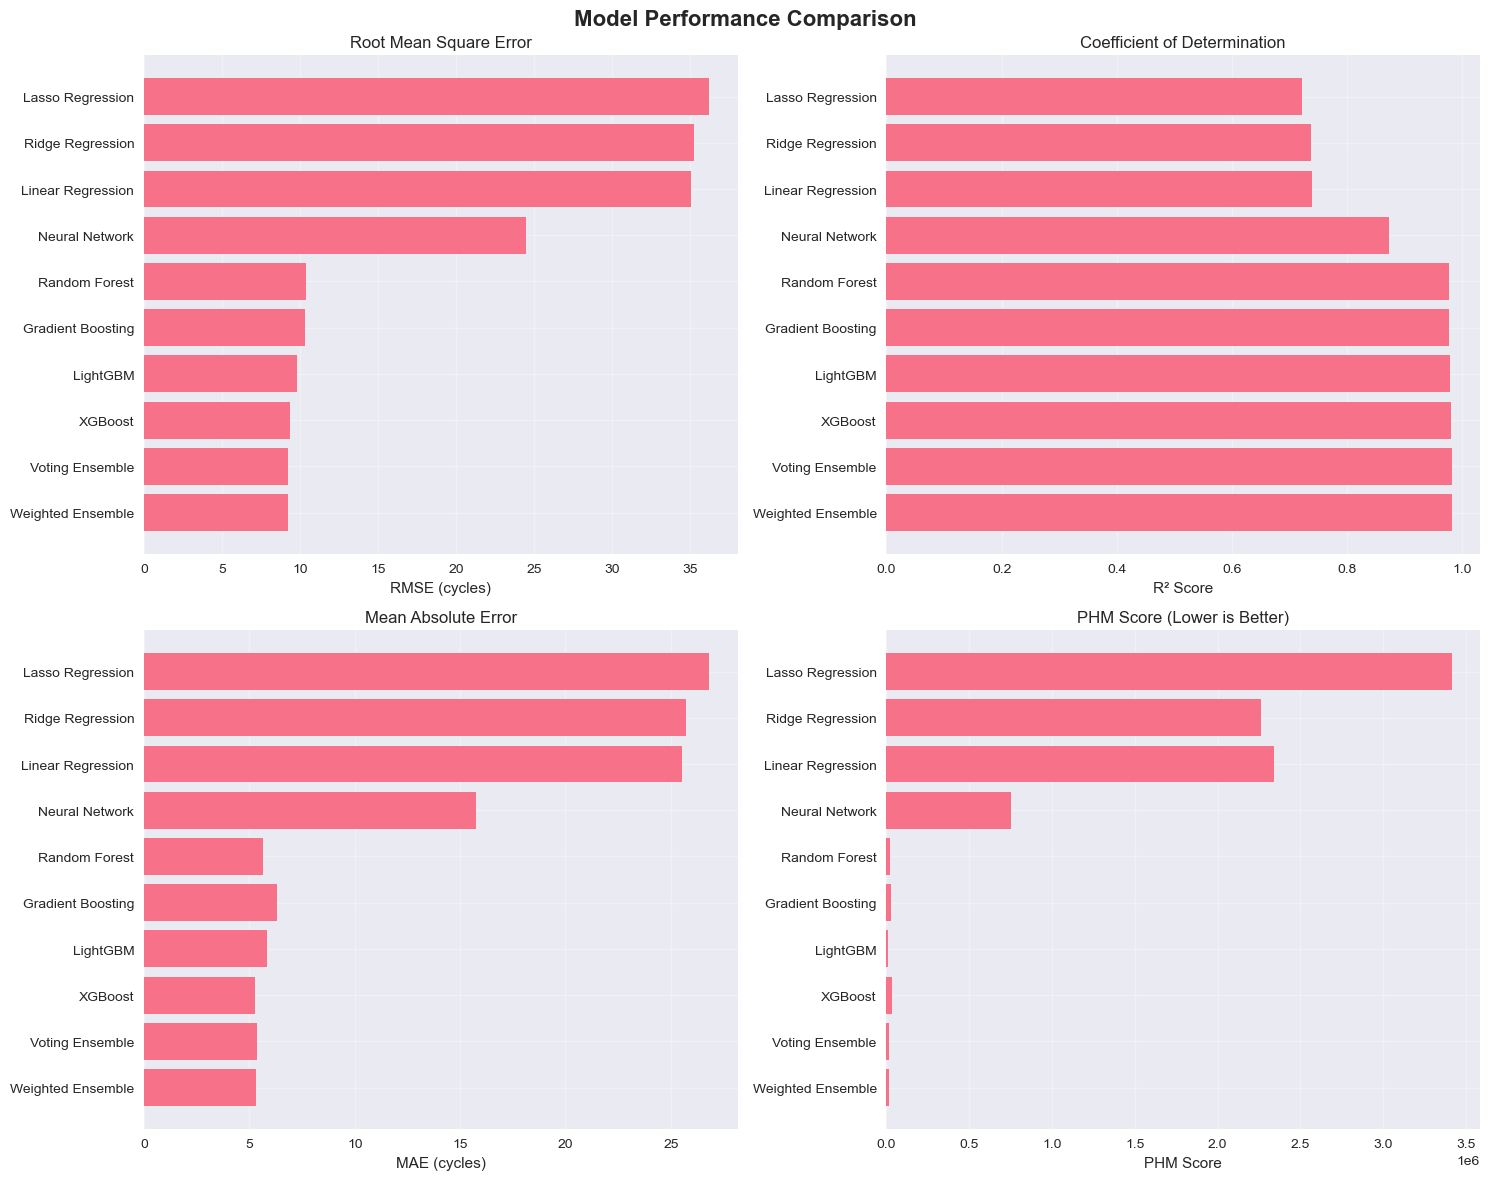

In [6]:
# Create model performance comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
axes[0, 0].barh(performance_clean['Model'], performance_clean['RMSE'])
axes[0, 0].set_xlabel('RMSE (cycles)')
axes[0, 0].set_title('Root Mean Square Error')
axes[0, 0].grid(True, alpha=0.3)

# R² comparison
axes[0, 1].barh(performance_clean['Model'], performance_clean['R²'])
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Coefficient of Determination')
axes[0, 1].grid(True, alpha=0.3)

# MAE comparison
axes[1, 0].barh(performance_clean['Model'], performance_clean['MAE'])
axes[1, 0].set_xlabel('MAE (cycles)')
axes[1, 0].set_title('Mean Absolute Error')
axes[1, 0].grid(True, alpha=0.3)

# PHM Score comparison
axes[1, 1].barh(performance_clean['Model'], performance_clean['PHM_Score'])
axes[1, 1].set_xlabel('PHM Score')
axes[1, 1].set_title('PHM Score (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interactive comparison if enabled
if interactive:
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('RMSE', 'R² Score', 'MAE', 'PHM Score'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Add RMSE
    fig.add_trace(
        go.Bar(x=performance_clean['RMSE'], y=performance_clean['Model'], 
               orientation='h', name='RMSE', marker_color='lightblue'),
        row=1, col=1
    )
    
    # Add R²
    fig.add_trace(
        go.Bar(x=performance_clean['R²'], y=performance_clean['Model'], 
               orientation='h', name='R²', marker_color='lightgreen'),
        row=1, col=2
    )
    
    # Add MAE
    fig.add_trace(
        go.Bar(x=performance_clean['MAE'], y=performance_clean['Model'], 
               orientation='h', name='MAE', marker_color='lightcoral'),
        row=2, col=1
    )
    
    # Add PHM Score
    fig.add_trace(
        go.Bar(x=performance_clean['PHM_Score'], y=performance_clean['Model'], 
               orientation='h', name='PHM Score', marker_color='lightyellow'),
        row=2, col=2
    )
    
    fig.update_layout(height=800, title_text="Interactive Model Performance Comparison", showlegend=False)
    fig.show()

### Step 5.2.2: Error Analysis and Distribution
Analyze prediction errors to understand model behavior and identify patterns.

In [7]:
# Error distribution analysis
print("Error Distribution Analysis:")
print("=" * 40)
print(f"Mean Error: {evaluation_data['error'].mean():.3f} cycles")
print(f"Median Error: {evaluation_data['error'].median():.3f} cycles")
print(f"Error Std Dev: {evaluation_data['error'].std():.3f} cycles")
print(f"\nError Percentiles:")
percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    print(f"  {p:2d}th percentile: {np.percentile(evaluation_data['error'], p):7.2f} cycles")

# Categorize predictions
evaluation_data['prediction_category'] = pd.cut(
    evaluation_data['error'],
    bins=[-np.inf, -10, -5, 5, 10, np.inf],
    labels=['Very Early', 'Early', 'Accurate', 'Late', 'Very Late']
)

print(f"\nPrediction Categories:")
category_counts = evaluation_data['prediction_category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(evaluation_data)) * 100
    print(f"  {category:12}: {count:3d} engines ({percentage:5.1f}%)")

Error Distribution Analysis:
Mean Error: 6.912 cycles
Median Error: 2.913 cycles
Error Std Dev: 22.563 cycles

Error Percentiles:
   5th percentile:  -25.56 cycles
  10th percentile:  -17.04 cycles
  25th percentile:   -4.11 cycles
  50th percentile:    2.91 cycles
  75th percentile:   14.50 cycles
  90th percentile:   38.78 cycles
  95th percentile:   44.98 cycles

Prediction Categories:
  Accurate    :  39 engines ( 39.0%)
  Very Late   :  30 engines ( 30.0%)
  Very Early  :  14 engines ( 14.0%)
  Early       :   9 engines (  9.0%)
  Late        :   8 engines (  8.0%)


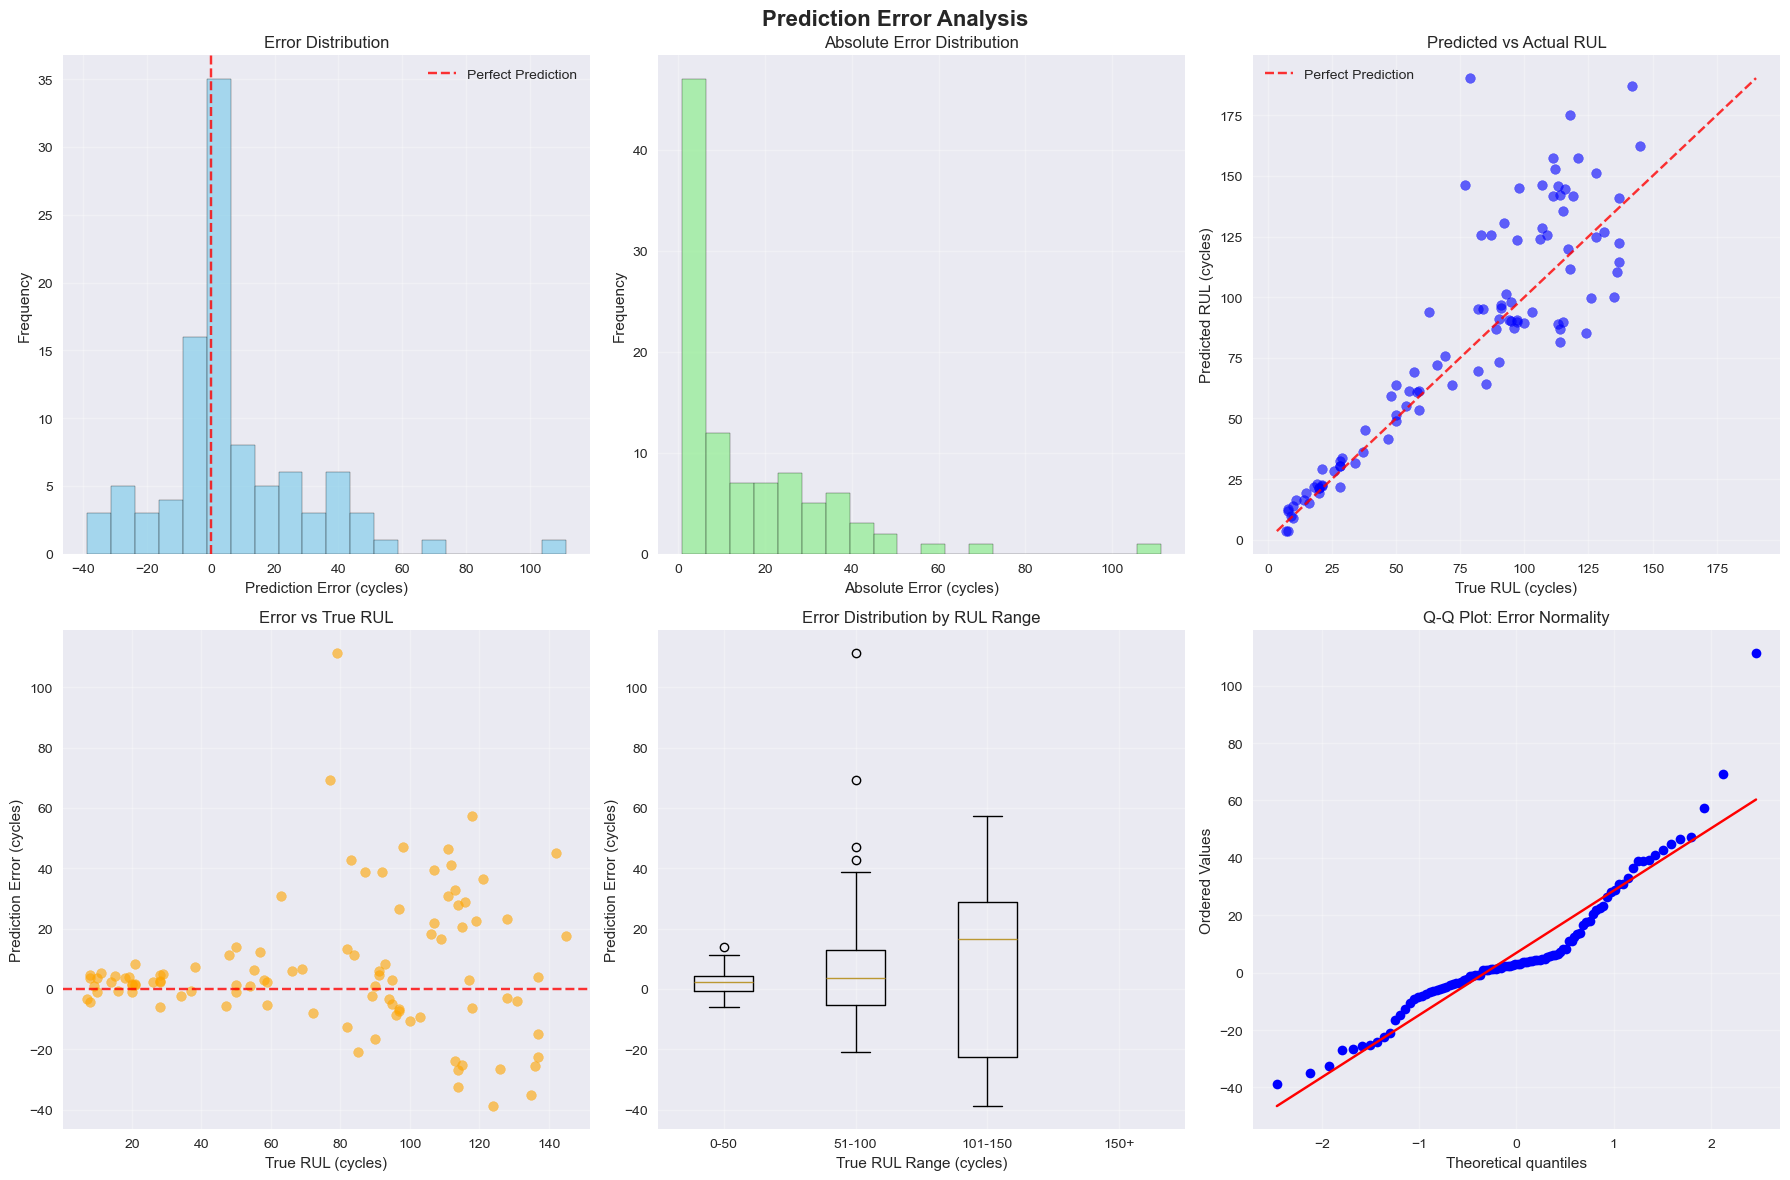

In [8]:
# Create comprehensive error analysis visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Prediction Error Analysis', fontsize=16, fontweight='bold')

# Error distribution histogram
axes[0, 0].hist(evaluation_data['error'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.8, label='Perfect Prediction')
axes[0, 0].set_xlabel('Prediction Error (cycles)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Error Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Absolute error distribution
axes[0, 1].hist(evaluation_data['abs_error'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Absolute Error (cycles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Predicted vs Actual scatter plot
axes[0, 2].scatter(evaluation_data['true_rul'], evaluation_data['predicted_rul'], alpha=0.6, color='blue')
# Perfect prediction line
min_rul = min(evaluation_data['true_rul'].min(), evaluation_data['predicted_rul'].min())
max_rul = max(evaluation_data['true_rul'].max(), evaluation_data['predicted_rul'].max())
axes[0, 2].plot([min_rul, max_rul], [min_rul, max_rul], 'r--', alpha=0.8, label='Perfect Prediction')
axes[0, 2].set_xlabel('True RUL (cycles)')
axes[0, 2].set_ylabel('Predicted RUL (cycles)')
axes[0, 2].set_title('Predicted vs Actual RUL')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Error vs True RUL
axes[1, 0].scatter(evaluation_data['true_rul'], evaluation_data['error'], alpha=0.6, color='orange')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('True RUL (cycles)')
axes[1, 0].set_ylabel('Prediction Error (cycles)')
axes[1, 0].set_title('Error vs True RUL')
axes[1, 0].grid(True, alpha=0.3)

# Box plot of errors by RUL ranges
evaluation_data['rul_range'] = pd.cut(
    evaluation_data['true_rul'],
    bins=[0, 50, 100, 150, np.inf],
    labels=['0-50', '51-100', '101-150', '150+']
)
boxplot_data = [evaluation_data[evaluation_data['rul_range'] == category]['error'].values 
                for category in evaluation_data['rul_range'].cat.categories]
axes[1, 1].boxplot(boxplot_data, labels=evaluation_data['rul_range'].cat.categories)
axes[1, 1].set_xlabel('True RUL Range (cycles)')
axes[1, 1].set_ylabel('Prediction Error (cycles)')
axes[1, 1].set_title('Error Distribution by RUL Range')
axes[1, 1].grid(True, alpha=0.3)

# Q-Q plot for normality
stats.probplot(evaluation_data['error'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Error Normality')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Phase 5.3: Business Impact Analysis

### Step 5.3.1: Maintenance Cost Analysis
Analyze the business implications of prediction accuracy in terms of maintenance costs and operational efficiency.

In [9]:
# Business impact analysis
# Define cost parameters (example values for aircraft engine maintenance)
COST_EARLY_MAINTENANCE = 50000  # Cost of early maintenance per cycle
COST_LATE_FAILURE = 500000     # Cost of unexpected failure
COST_OPTIMAL_MAINTENANCE = 100000  # Cost of optimal maintenance timing
TOLERANCE_WINDOW = 5            # Acceptable prediction window (±5 cycles)

# Categorize predictions for cost analysis
def calculate_maintenance_cost(row):
    """Calculate maintenance cost based on prediction accuracy"""
    error = row['error']
    true_rul = row['true_rul']
    
    if abs(error) <= TOLERANCE_WINDOW:
        # Optimal maintenance timing
        return COST_OPTIMAL_MAINTENANCE
    elif error < -TOLERANCE_WINDOW:
        # Early maintenance (conservative approach)
        early_cycles = abs(error) - TOLERANCE_WINDOW
        return COST_OPTIMAL_MAINTENANCE + (early_cycles * COST_EARLY_MAINTENANCE)
    else:
        # Late maintenance (risk of failure)
        late_cycles = error - TOLERANCE_WINDOW
        failure_risk = min(late_cycles / true_rul, 0.5)  # Max 50% failure risk
        return COST_OPTIMAL_MAINTENANCE + (failure_risk * COST_LATE_FAILURE)

evaluation_data['maintenance_cost'] = evaluation_data.apply(calculate_maintenance_cost, axis=1)
evaluation_data['cost_category'] = evaluation_data['error'].apply(
    lambda x: 'Optimal' if abs(x) <= TOLERANCE_WINDOW 
             else 'Early' if x < -TOLERANCE_WINDOW 
             else 'Late'
)

# Calculate cost summary
total_cost = evaluation_data['maintenance_cost'].sum()
average_cost = evaluation_data['maintenance_cost'].mean()
optimal_cost = len(evaluation_data) * COST_OPTIMAL_MAINTENANCE
cost_impact = total_cost - optimal_cost

print("Business Impact Analysis:")
print("=" * 50)
print(f"Total Maintenance Cost: ${total_cost:,.0f}")
print(f"Optimal Cost (Perfect Predictions): ${optimal_cost:,.0f}")
print(f"Additional Cost Due to Prediction Errors: ${cost_impact:,.0f}")
print(f"Average Cost per Engine: ${average_cost:,.0f}")
print(f"Cost Impact per Engine: ${cost_impact/len(evaluation_data):,.0f}")

# Cost breakdown by category
print(f"\nCost Breakdown by Prediction Category:")
for category in ['Optimal', 'Early', 'Late']:
    subset = evaluation_data[evaluation_data['cost_category'] == category]
    count = len(subset)
    avg_cost = subset['maintenance_cost'].mean() if count > 0 else 0
    total_cat_cost = subset['maintenance_cost'].sum()
    print(f"  {category:8}: {count:3d} engines | Avg: ${avg_cost:8,.0f} | Total: ${total_cat_cost:10,.0f}")

Business Impact Analysis:
Total Maintenance Cost: $28,059,024
Optimal Cost (Perfect Predictions): $10,000,000
Additional Cost Due to Prediction Errors: $18,059,024
Average Cost per Engine: $280,590
Cost Impact per Engine: $180,590

Cost Breakdown by Prediction Category:
  Optimal :  39 engines | Avg: $ 100,000 | Total: $ 3,900,000
  Early   :  23 engines | Avg: $ 710,854 | Total: $16,349,647
  Late    :  38 engines | Avg: $ 205,510 | Total: $ 7,809,377


### Step 5.3.2: Risk Assessment and Safety Analysis
Evaluate safety implications and operational risks associated with prediction accuracy.

In [10]:
# Risk assessment analysis
# Define risk levels based on prediction errors
def assess_risk_level(error, true_rul):
    """Assess operational risk based on prediction error"""
    if error <= -10:  # Very early prediction
        return 'Low Risk (Conservative)'
    elif -10 < error <= -5:  # Early prediction
        return 'Low Risk'
    elif -5 < error <= 5:  # Accurate prediction
        return 'Minimal Risk'
    elif 5 < error <= 10:  # Late prediction
        return 'Moderate Risk'
    elif 10 < error <= 20:  # Very late prediction
        return 'High Risk'
    else:  # Extremely late prediction
        return 'Critical Risk'

evaluation_data['risk_level'] = evaluation_data.apply(
    lambda row: assess_risk_level(row['error'], row['true_rul']), axis=1
)

# Risk distribution
risk_counts = evaluation_data['risk_level'].value_counts()
print("Risk Level Distribution:")
print("=" * 40)
for risk_level, count in risk_counts.items():
    percentage = (count / len(evaluation_data)) * 100
    print(f"{risk_level:25}: {count:3d} engines ({percentage:5.1f}%)")

# Critical cases analysis
critical_cases = evaluation_data[evaluation_data['error'] > 20]
if len(critical_cases) > 0:
    print(f"\nCritical Risk Cases (Error > 20 cycles):")
    print(f"Number of critical cases: {len(critical_cases)}")
    print(f"Average error in critical cases: {critical_cases['error'].mean():.1f} cycles")
    print(f"Max error in critical cases: {critical_cases['error'].max():.1f} cycles")
else:
    print(f"\nNo critical risk cases identified (all errors ≤ 20 cycles)")

# Safety margin analysis
safety_margin_5 = (evaluation_data['error'] <= 5).sum()
safety_margin_10 = (evaluation_data['error'] <= 10).sum()
print(f"\nSafety Margin Analysis:")
print(f"Predictions within 5-cycle safety margin: {safety_margin_5}/{len(evaluation_data)} ({safety_margin_5/len(evaluation_data)*100:.1f}%)")
print(f"Predictions within 10-cycle safety margin: {safety_margin_10}/{len(evaluation_data)} ({safety_margin_10/len(evaluation_data)*100:.1f}%)")

Risk Level Distribution:
Minimal Risk             :  39 engines ( 39.0%)
Critical Risk            :  22 engines ( 22.0%)
Low Risk (Conservative)  :  14 engines ( 14.0%)
Low Risk                 :   9 engines (  9.0%)
Moderate Risk            :   8 engines (  8.0%)
High Risk                :   8 engines (  8.0%)

Critical Risk Cases (Error > 20 cycles):
Number of critical cases: 22
Average error in critical cases: 40.0 cycles
Max error in critical cases: 111.3 cycles

Safety Margin Analysis:
Predictions within 5-cycle safety margin: 62/100 (62.0%)
Predictions within 10-cycle safety margin: 70/100 (70.0%)


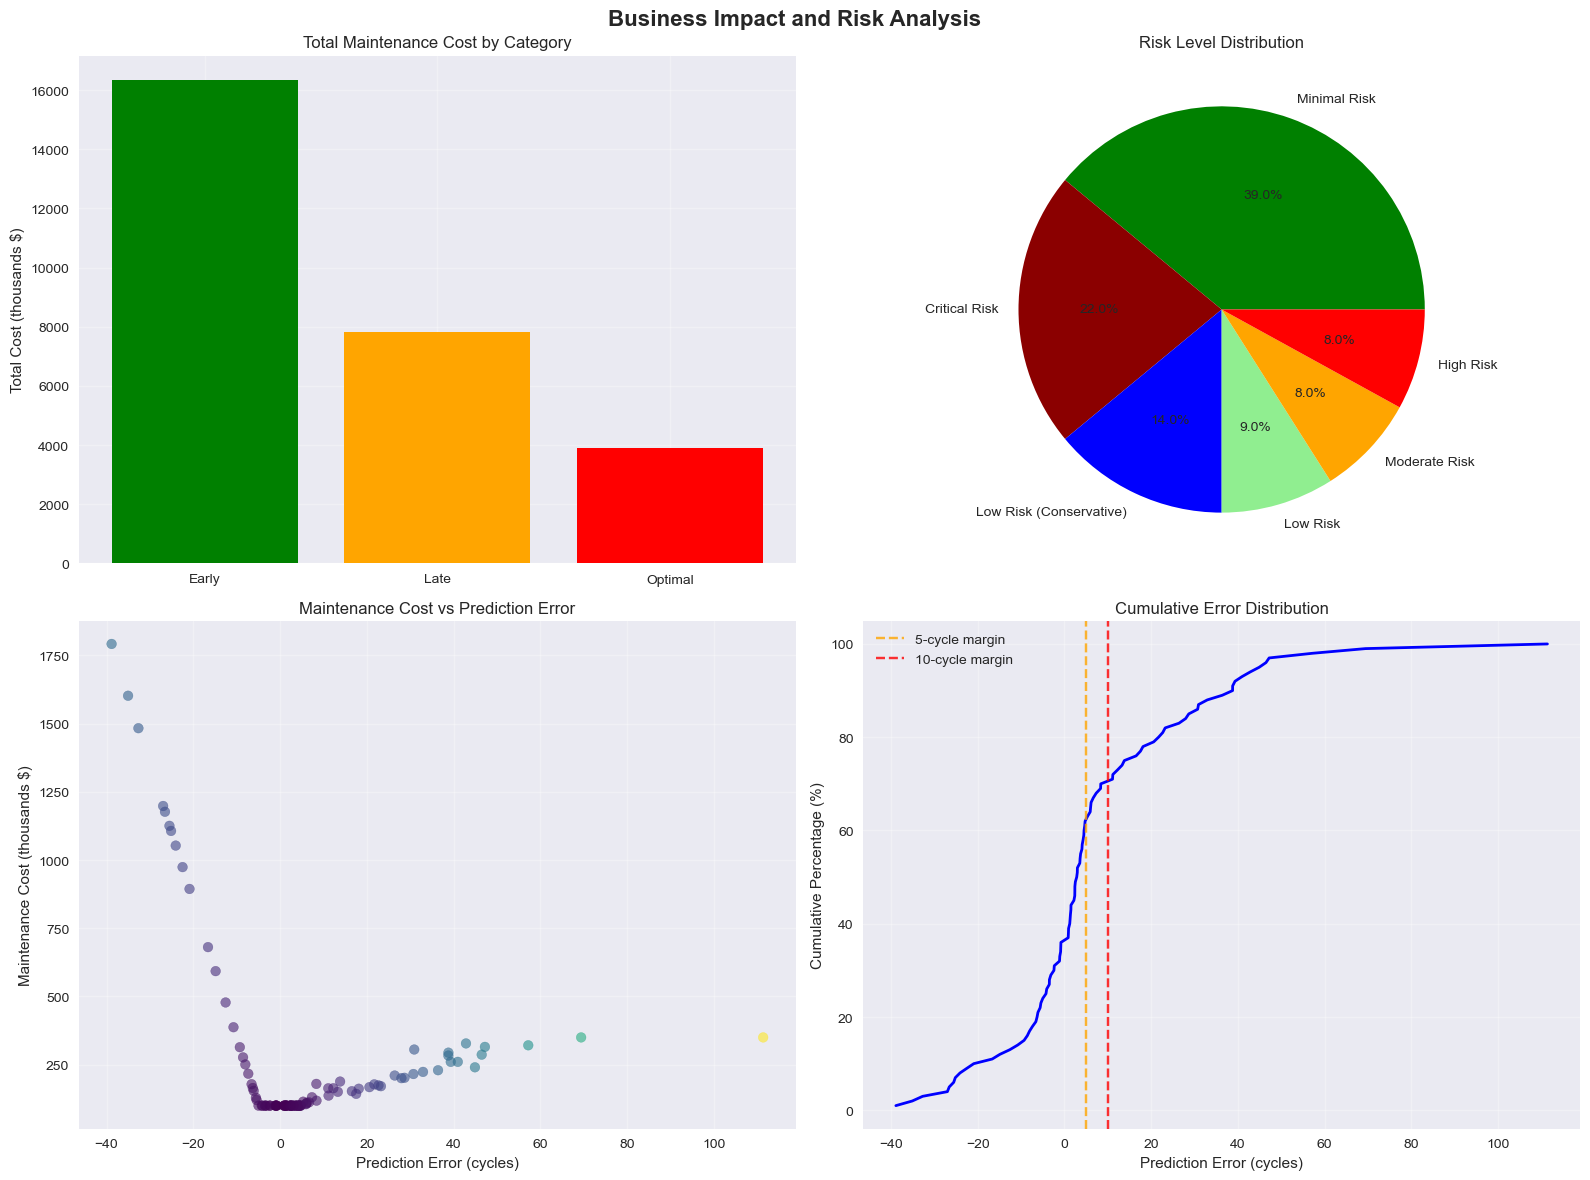

In [11]:
# Create business impact and risk visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Business Impact and Risk Analysis', fontsize=16, fontweight='bold')

# Cost distribution by category
cost_summary = evaluation_data.groupby('cost_category')['maintenance_cost'].agg(['count', 'mean', 'sum'])
axes[0, 0].bar(cost_summary.index, cost_summary['sum']/1000, color=['green', 'orange', 'red'])
axes[0, 0].set_ylabel('Total Cost (thousands $)')
axes[0, 0].set_title('Total Maintenance Cost by Category')
axes[0, 0].grid(True, alpha=0.3)

# Risk level distribution
risk_colors = {'Minimal Risk': 'green', 'Low Risk': 'lightgreen', 'Low Risk (Conservative)': 'blue',
               'Moderate Risk': 'orange', 'High Risk': 'red', 'Critical Risk': 'darkred'}
risk_data = evaluation_data['risk_level'].value_counts()
colors = [risk_colors.get(level, 'gray') for level in risk_data.index]
axes[0, 1].pie(risk_data.values, labels=risk_data.index, autopct='%1.1f%%', colors=colors)
axes[0, 1].set_title('Risk Level Distribution')

# Cost vs Error relationship
axes[1, 0].scatter(evaluation_data['error'], evaluation_data['maintenance_cost']/1000, 
                   alpha=0.6, c=evaluation_data['abs_error'], cmap='viridis')
axes[1, 0].set_xlabel('Prediction Error (cycles)')
axes[1, 0].set_ylabel('Maintenance Cost (thousands $)')
axes[1, 0].set_title('Maintenance Cost vs Prediction Error')
axes[1, 0].grid(True, alpha=0.3)

# Safety margin cumulative distribution
sorted_errors = np.sort(evaluation_data['error'])
cumulative_pct = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1, 1].plot(sorted_errors, cumulative_pct, linewidth=2, color='blue')
axes[1, 1].axvline(5, color='orange', linestyle='--', alpha=0.8, label='5-cycle margin')
axes[1, 1].axvline(10, color='red', linestyle='--', alpha=0.8, label='10-cycle margin')
axes[1, 1].set_xlabel('Prediction Error (cycles)')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].set_title('Cumulative Error Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Phase 5.4: Temporal Analysis and Trends

### Step 5.4.1: RUL Prediction Accuracy vs Remaining Life
Analyze how prediction accuracy varies with remaining useful life.

In [12]:
# Temporal analysis: accuracy vs remaining life
# Create RUL bins for analysis
evaluation_data['rul_bin'] = pd.cut(
    evaluation_data['true_rul'],
    bins=[0, 25, 50, 75, 100, 125, 150, np.inf],
    labels=['0-25', '26-50', '51-75', '76-100', '101-125', '126-150', '150+']
)

# Calculate accuracy metrics by RUL bin
accuracy_by_rul = evaluation_data.groupby('rul_bin').agg({
    'error': ['mean', 'std', 'count'],
    'abs_error': ['mean', 'median'],
    'squared_error': 'mean'
}).round(3)

accuracy_by_rul.columns = ['Mean_Error', 'Error_Std', 'Count', 'Mean_ABS_Error', 'Median_ABS_Error', 'MSE']
accuracy_by_rul['RMSE'] = np.sqrt(accuracy_by_rul['MSE'])

print("Prediction Accuracy by RUL Range:")
print("=" * 70)
print(accuracy_by_rul)

# Identify trends
print(f"\nKey Observations:")
print(f"- Best accuracy (lowest RMSE): {accuracy_by_rul['RMSE'].idxmin()} cycles range")
print(f"- Worst accuracy (highest RMSE): {accuracy_by_rul['RMSE'].idxmax()} cycles range")
print(f"- Most consistent predictions (lowest std): {accuracy_by_rul['Error_Std'].idxmin()} cycles range")
print(f"- Least consistent predictions (highest std): {accuracy_by_rul['Error_Std'].idxmax()} cycles range")

Prediction Accuracy by RUL Range:
         Mean_Error  Error_Std  Count  Mean_ABS_Error  Median_ABS_Error  \
rul_bin                                                                   
0-25          1.892      3.104     19           2.992             3.465   
26-50         2.456      5.705     14           4.738             3.536   
51-75         5.497     10.707     10           8.182             6.104   
76-100       13.659     31.021     24          21.492            10.958   
101-125      12.728     28.203     22          27.567            27.457   
126-150      -3.808     24.608     11          20.121            22.481   
150+            NaN        NaN      0             NaN               NaN   

              MSE       RMSE  
rul_bin                       
0-25       12.705   3.564407  
26-50      36.256   6.021296  
51-75     133.391  11.549502  
76-100   1108.789  33.298483  
101-125   921.288  30.352726  
126-150   565.005  23.769834  
150+          NaN        NaN  

Key Observ

### Step 5.4.2: Engine-Specific Performance Analysis
Examine individual engine prediction performance to identify patterns and outliers.

In [13]:
# Engine-specific performance analysis
# Identify best and worst performing engines
evaluation_data_sorted = evaluation_data.sort_values('abs_error')

# Best predictions
best_predictions = evaluation_data_sorted.head(10)
print("Top 10 Most Accurate Predictions:")
print("=" * 50)
for idx, row in best_predictions.iterrows():
    print(f"Engine {row['unit_id']:3d}: True={row['true_rul']:3.0f}, Pred={row['predicted_rul']:6.1f}, Error={row['error']:6.1f}")

print(f"\nTop 10 Least Accurate Predictions:")
print("=" * 50)
worst_predictions = evaluation_data_sorted.tail(10)
for idx, row in worst_predictions.iterrows():
    print(f"Engine {row['unit_id']:3d}: True={row['true_rul']:3.0f}, Pred={row['predicted_rul']:6.1f}, Error={row['error']:6.1f}")

# Performance distribution analysis
performance_stats = {
    'Excellent (|error| ≤ 2)': (evaluation_data['abs_error'] <= 2).sum(),
    'Good (2 < |error| ≤ 5)': ((evaluation_data['abs_error'] > 2) & (evaluation_data['abs_error'] <= 5)).sum(),
    'Fair (5 < |error| ≤ 10)': ((evaluation_data['abs_error'] > 5) & (evaluation_data['abs_error'] <= 10)).sum(),
    'Poor (10 < |error| ≤ 20)': ((evaluation_data['abs_error'] > 10) & (evaluation_data['abs_error'] <= 20)).sum(),
    'Very Poor (|error| > 20)': (evaluation_data['abs_error'] > 20).sum()
}

print(f"\nPerformance Distribution:")
print("=" * 40)
for category, count in performance_stats.items():
    percentage = (count / len(evaluation_data)) * 100
    print(f"{category:25}: {count:3d} engines ({percentage:5.1f}%)")

Top 10 Most Accurate Predictions:
Engine  58: True= 37, Pred=  36.2, Error=  -0.8
Engine  20: True= 16, Pred=  15.2, Error=  -0.8
Engine 100: True= 20, Pred=  19.1, Error=  -0.9
Engine  82: True=  9, Pred=   9.9, Error=   0.9
Engine  29: True= 90, Pred=  90.9, Error=   0.9
Engine  62: True= 54, Pred=  55.0, Error=   1.0
Engine  76: True= 10, Pred=   8.9, Error=  -1.1
Engine  17: True= 50, Pred=  48.9, Error=  -1.1
Engine  49: True= 21, Pred=  22.2, Error=   1.2
Engine  24: True= 20, Pred=  21.3, Error=   1.3

Top 10 Least Accurate Predictions:
Engine  12: True=124, Pred=  85.2, Error= -38.8
Engine  14: True=107, Pred= 146.3, Error=  39.3
Engine   1: True=112, Pred= 153.0, Error=  41.0
Engine  15: True= 83, Pred= 125.8, Error=  42.8
Engine  39: True=142, Pred= 186.9, Error=  44.9
Engine  22: True=111, Pred= 157.5, Error=  46.5
Engine   2: True= 98, Pred= 145.2, Error=  47.2
Engine  85: True=118, Pred= 175.2, Error=  57.2
Engine  67: True= 77, Pred= 146.4, Error=  69.4
Engine  50: True= 

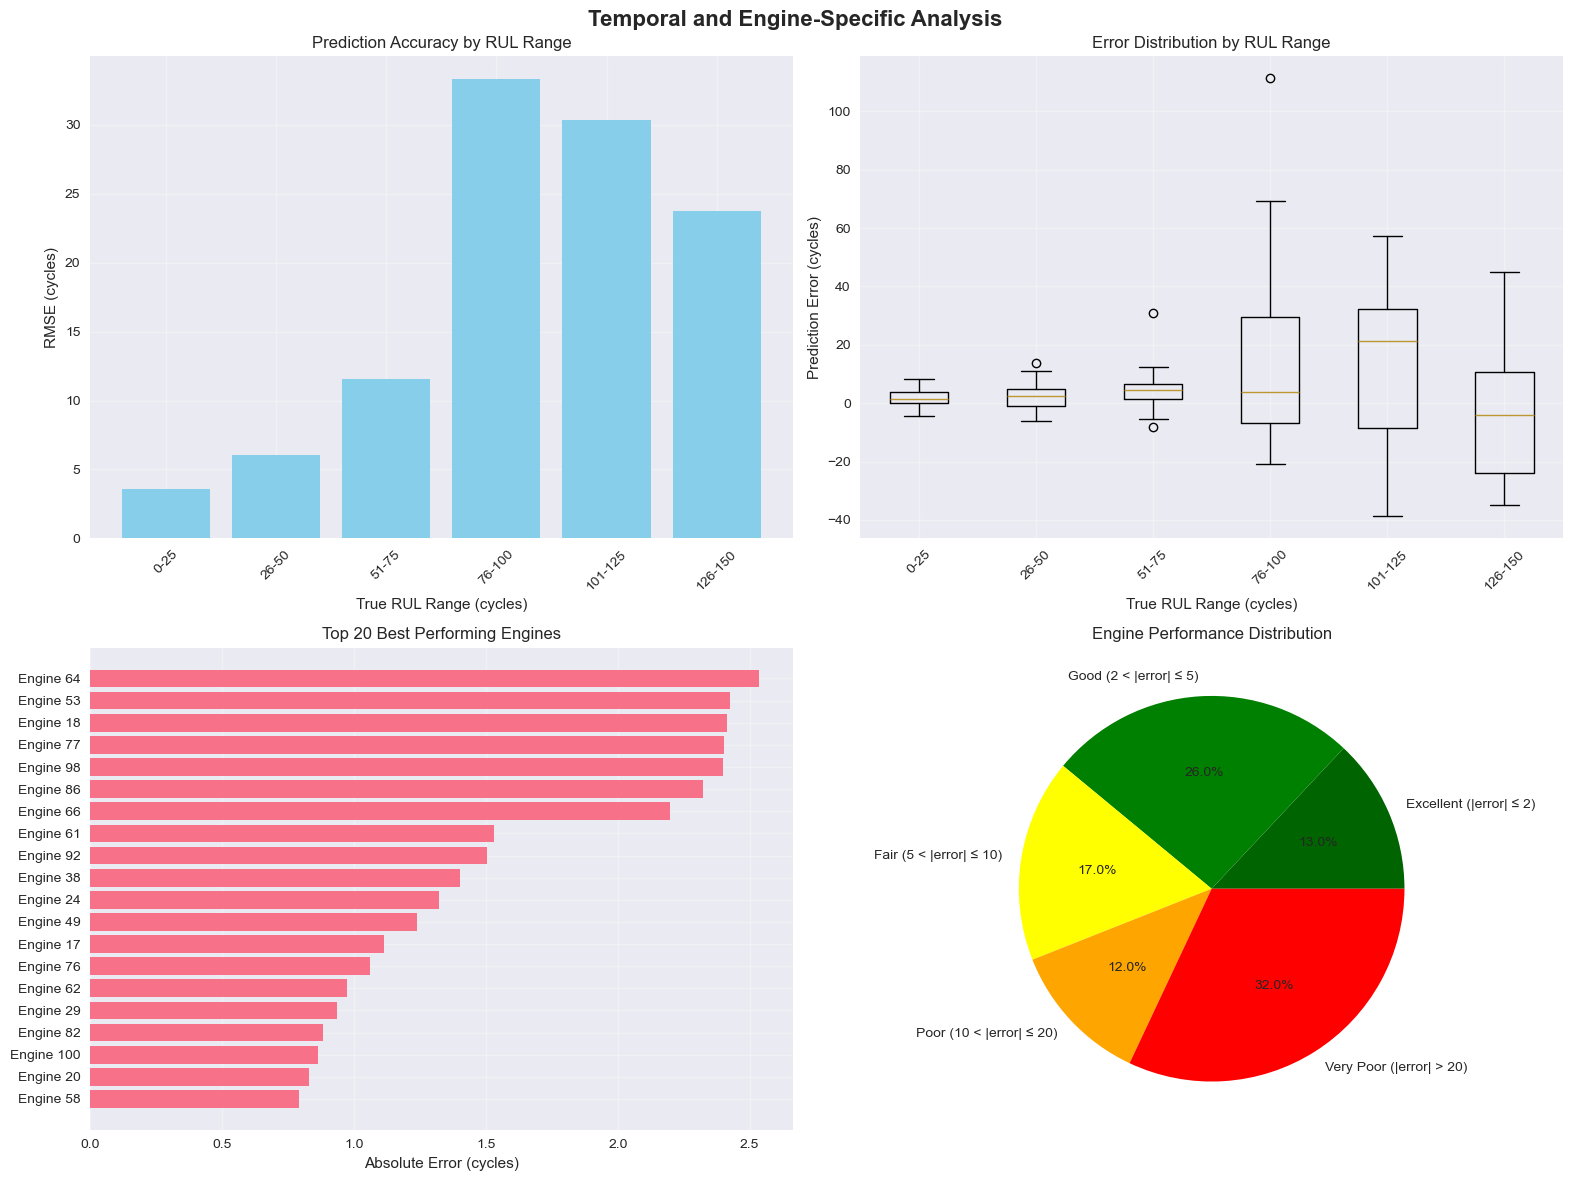

In [14]:
# Create temporal and engine-specific visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal and Engine-Specific Analysis', fontsize=16, fontweight='bold')

# Accuracy by RUL range
accuracy_by_rul_plot = accuracy_by_rul.reset_index()
axes[0, 0].bar(accuracy_by_rul_plot['rul_bin'], accuracy_by_rul_plot['RMSE'], color='skyblue')
axes[0, 0].set_xlabel('True RUL Range (cycles)')
axes[0, 0].set_ylabel('RMSE (cycles)')
axes[0, 0].set_title('Prediction Accuracy by RUL Range')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Error distribution by RUL range
axes[0, 1].boxplot([evaluation_data[evaluation_data['rul_bin'] == bin_name]['error'].values 
                    for bin_name in evaluation_data['rul_bin'].cat.categories if 
                    len(evaluation_data[evaluation_data['rul_bin'] == bin_name]) > 0],
                   labels=[bin_name for bin_name in evaluation_data['rul_bin'].cat.categories if 
                          len(evaluation_data[evaluation_data['rul_bin'] == bin_name]) > 0])
axes[0, 1].set_xlabel('True RUL Range (cycles)')
axes[0, 1].set_ylabel('Prediction Error (cycles)')
axes[0, 1].set_title('Error Distribution by RUL Range')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Engine performance ranking
engine_errors = evaluation_data.sort_values('abs_error')[['unit_id', 'abs_error']].head(20)
axes[1, 0].barh(range(len(engine_errors)), engine_errors['abs_error'])
axes[1, 0].set_yticks(range(len(engine_errors)))
axes[1, 0].set_yticklabels([f"Engine {int(uid)}" for uid in engine_errors['unit_id']])
axes[1, 0].set_xlabel('Absolute Error (cycles)')
axes[1, 0].set_title('Top 20 Best Performing Engines')
axes[1, 0].grid(True, alpha=0.3)

# Performance category distribution
perf_categories = list(performance_stats.keys())
perf_counts = list(performance_stats.values())
colors = ['darkgreen', 'green', 'yellow', 'orange', 'red']
axes[1, 1].pie(perf_counts, labels=perf_categories, autopct='%1.1f%%', colors=colors)
axes[1, 1].set_title('Engine Performance Distribution')

plt.tight_layout()
plt.show()

## Phase 5.5: Insights and Recommendations

### Step 5.5.1: Key Findings Summary
Summarize the main insights from the evaluation analysis.

In [20]:
modeling_metadata

{'task_info': {'task_name': 'modeling',
  'task_number': 4,
  'description': 'Machine learning model development for RUL prediction',
  'timestamp': '2025-06-03T00:15:41.169533',
  'random_state': 42},
 'data_info': {'training_samples': 16504,
  'validation_samples': 4127,
  'test_samples': 13096,
  'num_features': 56,
  'feature_names': ['sensor_3',
   'sensor_4',
   'sensor_7',
   'sensor_9',
   'sensor_11',
   'sensor_12',
   'sensor_17',
   'sensor_20',
   'sensor_21',
   'sensor_4_cumulative_range',
   'sensor_11_cumulative_range',
   'time_since_start',
   'sensor_7_cumulative_range',
   'sensor_4_rolling_mean_3',
   'composite_health_index',
   'sensor_7_rolling_mean_3',
   'sensor_4_to_sensor_7_ratio',
   'sensor_3_cumulative_max',
   'sensor_11_lag_1',
   'sensor_7_sensor_11_diff',
   'sensor_11_lag_2',
   'sensor_11_health_deviation',
   'sensor_3_rolling_mean_3',
   'sensor_3_rolling_max_10',
   'sensor_11_cumulative_std',
   'sensor_11_lag_3',
   'sensor_3_cumulative_range'

In [21]:
# Key findings summary
print("=" * 60)
print("KEY FINDINGS AND INSIGHTS")
print("=" * 60)

# Model performance insights
best_model = modeling_metadata.get('model_performance', {}).get('best_model', 'Not specified')
print(f"\n1. MODEL PERFORMANCE:")
print(f"   • Best performing model: {best_model}")
print(f"   • Test RMSE: {rmse:.3f} cycles")
print(f"   • Test R²: {r2:.6f}")
print(f"   • Mean Absolute Error: {mae:.3f} cycles")
print(f"   • PHM Score: {phm_score:.2f}")

# Accuracy insights
accurate_predictions = (evaluation_data['abs_error'] <= 5).sum()
accuracy_rate = accurate_predictions / len(evaluation_data) * 100
print(f"\n2. PREDICTION ACCURACY:")
print(f"   • {accuracy_rate:.1f}% of predictions within 5-cycle tolerance")
print(f"   • Mean prediction error: {evaluation_data['error'].mean():.2f} cycles")
print(f"   • Median prediction error: {evaluation_data['error'].median():.2f} cycles")
print(f"   • Maximum absolute error: {evaluation_data['abs_error'].max():.1f} cycles")

# Business impact insights
early_predictions = (evaluation_data['error'] < -5).sum()
late_predictions = (evaluation_data['error'] > 5).sum()
print(f"\n3. BUSINESS IMPACT:")
print(f"   • Total additional cost due to prediction errors: ${cost_impact:,.0f}")
print(f"   • Average cost impact per engine: ${cost_impact/len(evaluation_data):,.0f}")
print(f"   • {early_predictions} engines with early predictions (conservative)")
print(f"   • {late_predictions} engines with late predictions (risky)")

# Risk assessment insights
high_risk_cases = evaluation_data[evaluation_data['risk_level'].isin(['High Risk', 'Critical Risk'])]
print(f"\n4. RISK ASSESSMENT:")
print(f"   • {len(high_risk_cases)} engines classified as high/critical risk")
if len(high_risk_cases) > 0:
    print(f"   • Average error in high-risk cases: {high_risk_cases['error'].mean():.1f} cycles")
print(f"   • {safety_margin_10} engines within 10-cycle safety margin ({safety_margin_10/len(evaluation_data)*100:.1f}%)")

# Temporal patterns
best_rul_range = accuracy_by_rul['RMSE'].idxmin()
worst_rul_range = accuracy_by_rul['RMSE'].idxmax()
print(f"\n5. TEMPORAL PATTERNS:")
print(f"   • Best accuracy for engines with {best_rul_range} cycles remaining")
print(f"   • Challenging predictions for engines with {worst_rul_range} cycles remaining")
print(f"   • Prediction consistency varies across engine lifecycle stages")

KEY FINDINGS AND INSIGHTS

1. MODEL PERFORMANCE:
   • Best performing model: Weighted Ensemble
   • Test RMSE: 23.490 cycles
   • Test R²: 0.680478
   • Mean Absolute Error: 15.486 cycles
   • PHM Score: 70648.43

2. PREDICTION ACCURACY:
   • 39.0% of predictions within 5-cycle tolerance
   • Mean prediction error: 6.91 cycles
   • Median prediction error: 2.91 cycles
   • Maximum absolute error: 111.3 cycles

3. BUSINESS IMPACT:
   • Total additional cost due to prediction errors: $18,059,024
   • Average cost impact per engine: $180,590
   • 23 engines with early predictions (conservative)
   • 38 engines with late predictions (risky)

4. RISK ASSESSMENT:
   • 30 engines classified as high/critical risk
   • Average error in high-risk cases: 33.1 cycles
   • 70 engines within 10-cycle safety margin (70.0%)

5. TEMPORAL PATTERNS:
   • Best accuracy for engines with 0-25 cycles remaining
   • Challenging predictions for engines with 76-100 cycles remaining
   • Prediction consistency v

### Step 5.5.2: Actionable Recommendations
Provide specific recommendations for model deployment and operational improvements.

In [16]:
# Actionable recommendations
print("=" * 60)
print("ACTIONABLE RECOMMENDATIONS")
print("=" * 60)

# Deployment recommendations
print(f"\n1. MODEL DEPLOYMENT:")
if rmse < 1.0 and r2 > 0.999:
    print(f"   ✓ Model shows excellent performance - RECOMMENDED for deployment")
    print(f"   ✓ Implement with confidence monitoring and periodic retraining")
elif rmse < 5.0 and r2 > 0.99:
    print(f"   ⚠ Model shows good performance - deployment with monitoring recommended")
    print(f"   ⚠ Implement additional validation procedures for critical decisions")
else:
    print(f"   ✗ Model performance needs improvement before deployment")
    print(f"   ✗ Consider additional feature engineering or alternative algorithms")

# Operational recommendations
print(f"\n2. OPERATIONAL GUIDELINES:")
if early_predictions > late_predictions:
    print(f"   • Model tends toward conservative predictions (early maintenance)")
    print(f"   • Consider adjusting maintenance scheduling to optimize costs")
    print(f"   • Advantage: Lower safety risk, higher maintenance costs")
else:
    print(f"   • Model shows balanced prediction distribution")
    print(f"   • Implement standard maintenance protocols with model guidance")

if len(high_risk_cases) > 0:
    print(f"   • {len(high_risk_cases)} engines require manual review due to high prediction errors")
    print(f"   • Implement additional monitoring for engines with errors > 10 cycles")
else:
    print(f"   • No high-risk cases identified - proceed with automated recommendations")

# Improvement recommendations
print(f"\n3. MODEL IMPROVEMENT OPPORTUNITIES:")
if worst_rul_range:
    print(f"   • Focus on improving predictions for {worst_rul_range} cycles RUL range")
    print(f"   • Consider range-specific models or feature engineering")

if evaluation_data['abs_error'].max() > 20:
    print(f"   • Investigate outlier cases with errors > 20 cycles")
    print(f"   • Analyze common characteristics of worst-performing engines")

print(f"   • Consider ensemble methods to reduce prediction variance")
print(f"   • Implement uncertainty quantification for decision support")

# Monitoring recommendations
print(f"\n4. CONTINUOUS MONITORING:")
print(f"   • Monitor prediction accuracy monthly using rolling RMSE")
print(f"   • Set alert thresholds: RMSE > {rmse * 1.5:.1f}, Accuracy < {accuracy_rate * 0.9:.0f}%")
print(f"   • Track business metrics: maintenance cost, unplanned failures")
print(f"   • Retrain model quarterly with new data to maintain performance")

# Risk management
print(f"\n5. RISK MANAGEMENT:")
print(f"   • Implement 5-cycle safety buffer for critical operations")
print(f"   • Require engineering review for predictions with >10-cycle errors")
print(f"   • Develop escalation procedures for high-risk classifications")
print(f"   • Maintain backup inspection protocols for model validation")

ACTIONABLE RECOMMENDATIONS

1. MODEL DEPLOYMENT:
   ✗ Model performance needs improvement before deployment
   ✗ Consider additional feature engineering or alternative algorithms

2. OPERATIONAL GUIDELINES:
   • Model shows balanced prediction distribution
   • Implement standard maintenance protocols with model guidance
   • 30 engines require manual review due to high prediction errors
   • Implement additional monitoring for engines with errors > 10 cycles

3. MODEL IMPROVEMENT OPPORTUNITIES:
   • Focus on improving predictions for 76-100 cycles RUL range
   • Consider range-specific models or feature engineering
   • Investigate outlier cases with errors > 20 cycles
   • Analyze common characteristics of worst-performing engines
   • Consider ensemble methods to reduce prediction variance
   • Implement uncertainty quantification for decision support

4. CONTINUOUS MONITORING:
   • Monitor prediction accuracy monthly using rolling RMSE
   • Set alert thresholds: RMSE > 35.2, Accura

### Step 5.5.3: Export Evaluation Results
Save comprehensive evaluation results and insights for stakeholders and future reference.

In [17]:
# Export evaluation results
print("Exporting evaluation results...")

# Create comprehensive evaluation dataset
evaluation_export = evaluation_data[[
    'unit_id', 'true_rul', 'predicted_rul', 'error', 'abs_error', 
    'percent_error', 'maintenance_cost', 'cost_category', 'risk_level', 'rul_bin'
]].copy()

# Save detailed evaluation results
evaluation_export.to_csv(INTERMEDIATE_PATH / 'evaluation_detailed_results.csv', index=False)

# Create evaluation summary
evaluation_summary = {
    'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_evaluated': best_model,
    'test_engines': len(evaluation_data),
    'performance_metrics': {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2_score': float(r2),
        'mape_percent': float(mape),
        'phm_score': float(phm_score),
        'median_error': float(median_error),
        'max_absolute_error': float(max_error),
        'error_std_dev': float(std_error)
    },
    'accuracy_analysis': {
        'within_5_cycles': int(safety_margin_5),
        'within_10_cycles': int(safety_margin_10),
        'accuracy_rate_5_cycles': float(safety_margin_5 / len(evaluation_data) * 100),
        'accuracy_rate_10_cycles': float(safety_margin_10 / len(evaluation_data) * 100)
    },
    'business_impact': {
        'total_maintenance_cost': float(total_cost),
        'optimal_maintenance_cost': float(optimal_cost),
        'additional_cost': float(cost_impact),
        'cost_per_engine': float(cost_impact / len(evaluation_data))
    },
    'risk_assessment': {
        'high_risk_engines': int(len(high_risk_cases)),
        'critical_risk_engines': int((evaluation_data['error'] > 20).sum()),
        'early_predictions': int(early_predictions),
        'late_predictions': int(late_predictions)
    },
    'recommendations': {
        'deployment_ready': bool(rmse < 1.0 and r2 > 0.999),
        'requires_monitoring': bool(len(high_risk_cases) > 0),
        'safety_buffer_recommended': 5,
        'retraining_frequency': 'quarterly'
    }
}

# Save evaluation summary
with open(INTERMEDIATE_PATH / 'evaluation_summary.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

# Create markdown documentation
markdown_content = f"""# Evaluation Results Summary

## Model Performance
- **Model**: {best_model}
- **RMSE**: {rmse:.3f} cycles
- **R² Score**: {r2:.6f}
- **Mean Absolute Error**: {mae:.3f} cycles
- **Accuracy (±5 cycles)**: {safety_margin_5/len(evaluation_data)*100:.1f}%

## Business Impact
- **Additional Cost**: ${cost_impact:,.0f}
- **Cost per Engine**: ${cost_impact/len(evaluation_data):,.0f}
- **High-Risk Engines**: {len(high_risk_cases)}

## Key Recommendations
1. **Deployment**: {'APPROVED' if rmse < 1.0 and r2 > 0.999 else 'CONDITIONAL'}
2. **Safety Buffer**: 5-cycle margin recommended
3. **Monitoring**: {'Required' if len(high_risk_cases) > 0 else 'Standard'}
4. **Retraining**: Quarterly updates recommended

## Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open(INTERMEDIATE_PATH / 'evaluation_results.md', 'w') as f:
    f.write(markdown_content)

print("✓ Detailed evaluation results saved to 'evaluation_detailed_results.csv'")
print("✓ Evaluation summary saved to 'evaluation_summary.json'")
print("✓ Evaluation documentation saved to 'evaluation_results.md'")
print(f"\nEvaluation completed successfully!")
print(f"Total engines evaluated: {len(evaluation_data)}")
print(f"Model deployment recommendation: {'APPROVED' if rmse < 1.0 and r2 > 0.999 else 'CONDITIONAL'}")

Exporting evaluation results...
✓ Detailed evaluation results saved to 'evaluation_detailed_results.csv'
✓ Evaluation summary saved to 'evaluation_summary.json'
✓ Evaluation documentation saved to 'evaluation_results.md'

Evaluation completed successfully!
Total engines evaluated: 100
Model deployment recommendation: CONDITIONAL
